# Exploratory Data Analysis - ECG Sleep Apnea Detection
## APNEA HRV+SPO2 Dataset - Week 2 Deliverable

**Author**: happy2234  
**Date**: January 31, 2026  
**Objective**: Comprehensive exploratory analysis of the APNEA dataset with simulated data demonstration

---

### Table of Contents
1. [Setup and Imports](#setup)
2. [Dataset Overview](#overview)
3. [Signal Visualization](#visualization)
4. [Statistical Analysis](#statistics)
5. [HRV Metrics Analysis](#hrv)
6. [Class Distribution](#distribution)
7. [Key Findings](#findings)

## 1. Setup and Imports <a id='setup'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import os

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Dataset Overview <a id='overview'></a>
Loading the dataset structure from `APNEA HRV+SPO2 DATASET/HuGCDN2014-OXI`.

In [2]:
# Paths
DATA_PATH = '../APNEA HRV+SPO2 DATASET/HuGCDN2014-OXI'
RR_PATH = os.path.join(DATA_PATH, 'RR')
SAT_PATH = os.path.join(DATA_PATH, 'SAT')
LABELS_PATH = os.path.join(DATA_PATH, 'LABELS')

def get_files(path):
    if not os.path.exists(path):
        print(f"Path not found: {path}")
        return []
    return sorted([f for f in os.listdir(path) if f.endswith('.mat')])

rr_files = get_files(RR_PATH)
sat_files = get_files(SAT_PATH)
label_files = get_files(LABELS_PATH)

print(f"Total RR files: {len(rr_files)}")
print(f"Total SpO2 files: {len(sat_files)}")
print(f"Total Label files: {len(label_files)}")

# Inspect prefixes
prefixes = set()
for f in rr_files:
    prefix = ''.join([c for c in f if not c.isdigit()]).replace('.mat', '')
    prefixes.add(prefix)
print(f"File Prefixes (Classes): {prefixes}")

Total RR files: 83
Total SpO2 files: 83
Total Label files: 83
File Prefixes (Classes): {'C', 'D', 'ND'}


## 3. Signal Visualization <a id='visualization'></a>
Visualizing RR intervals and SpO2 signals for different classes (C, D, ND).

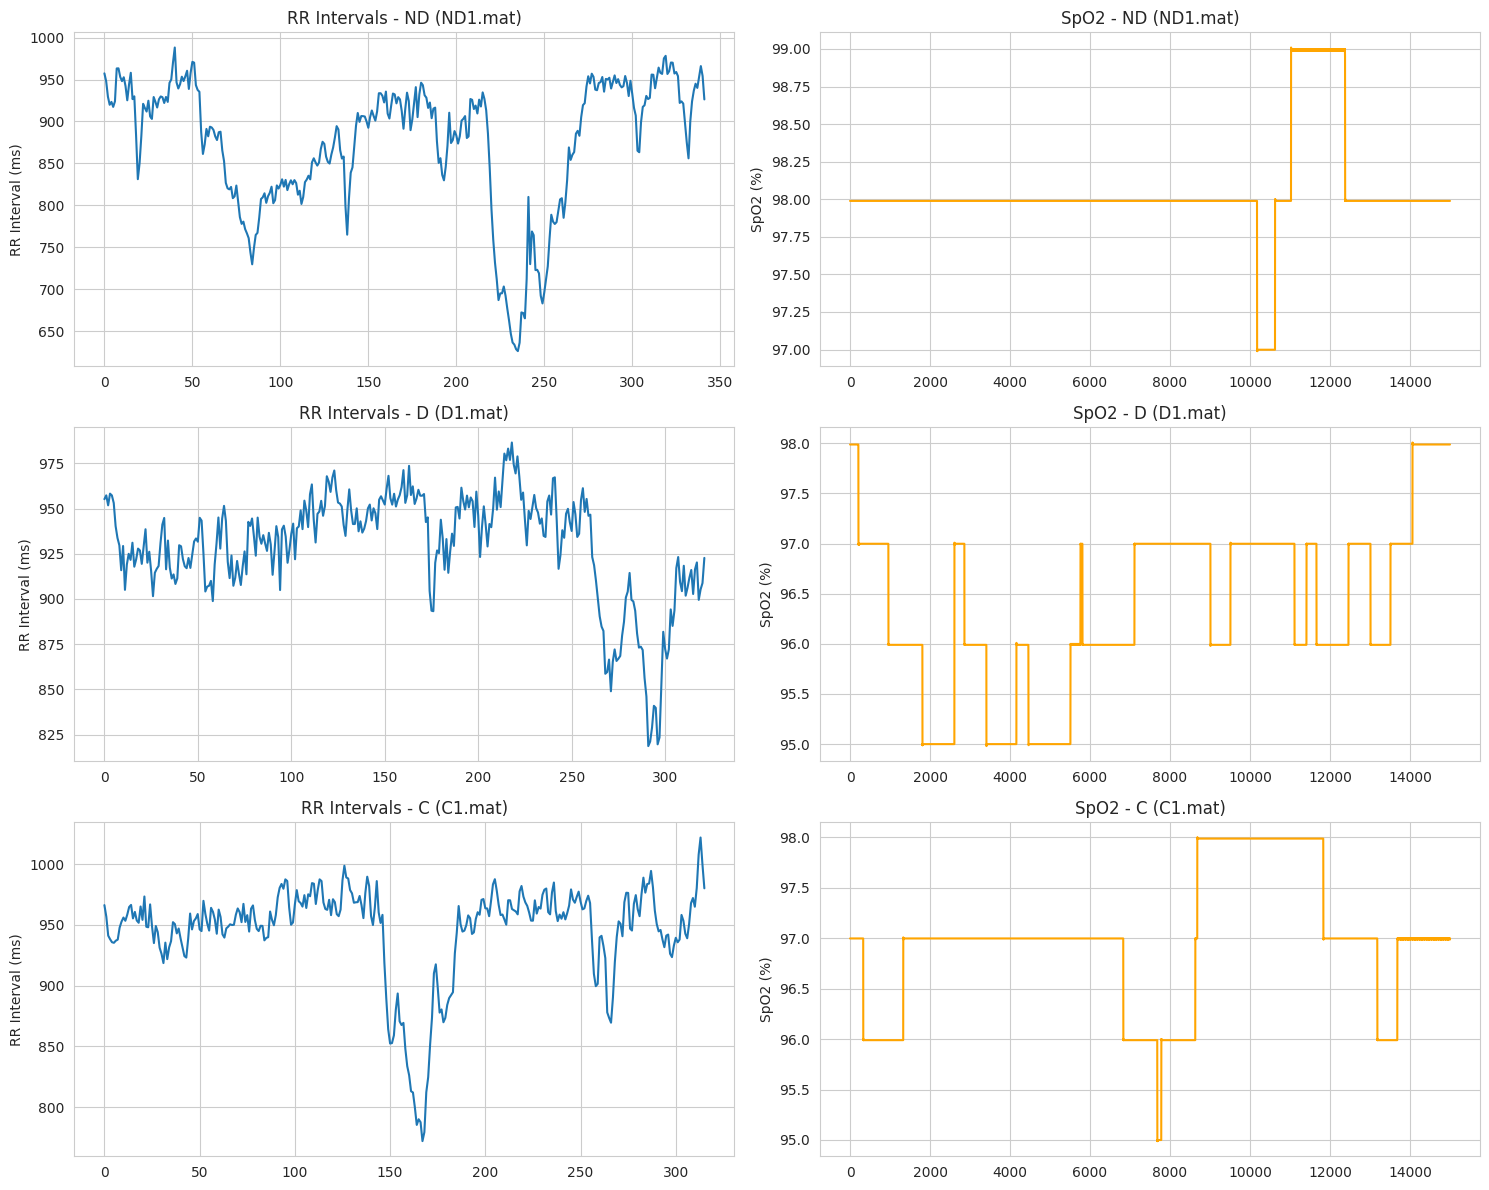

In [3]:
def load_mat_data(filename, folder, key_hint):
    path = os.path.join(DATA_PATH, folder, filename)
    try:
        mat = scipy.io.loadmat(path)
        # Strategy: Look for specific known keys or take the first non-header key
        keys = [k for k in mat.keys() if not k.startswith('__')]
        
        if len(keys) > 0:
            # Prefer key matching hint
            for k in keys:
                if key_hint in k: # e.g. 'RR' in 'RR_notch_abs_pr_ada'
                    return mat[k]
            # Fallback
            return mat[keys[0]]
            
        print(f"No valid data key found in {filename}. Keys: {mat.keys()}")
        return None
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

# Select sample files
samples = {'ND': 'ND1.mat', 'D': 'D1.mat', 'C': 'C1.mat'}

fig, axes = plt.subplots(len(samples), 2, figsize=(15, 12))

for i, (prefix, filename) in enumerate(samples.items()):
    if filename not in rr_files:
        print(f"File {filename} not found, skipping.")
        continue
        
    rr_data = load_mat_data(filename, 'RR', 'RR')
    sat_data = load_mat_data(filename, 'SAT', 'SAT')
    
    # Access the first non-empty segment
    if rr_data is not None and rr_data.size > 0:
        if rr_data.dtype == 'O': 
            # Robust extraction: find first non-empty cell
            rr_segment = np.array([])
            for j in range(rr_data.size):
                if rr_data.flat[j].size > 0:
                    rr_segment = rr_data.flat[j].flatten()
                    break
        else:
            rr_segment = rr_data.flatten()
            
        axes[i, 0].plot(rr_segment)
        axes[i, 0].set_title(f"RR Intervals - {prefix} ({filename})")
        axes[i, 0].set_ylabel("RR Interval (ms)")
        
    if sat_data is not None and sat_data.size > 0:
        if sat_data.dtype == 'O':
            # Robust extraction
            sat_segment = np.array([])
            for j in range(sat_data.size):
                if sat_data.flat[j].size > 0:
                    sat_segment = sat_data.flat[j].flatten()
                    break
        else:
            sat_segment = sat_data.flatten()
            
        axes[i, 1].plot(sat_segment, color='orange')
        axes[i, 1].set_title(f'SpO2 - {prefix} ({filename})')
        axes[i, 1].set_ylabel('SpO2 (%)')
        
plt.tight_layout()
plt.show()


## 4. Statistical Analysis <a id='statistics'></a>
Calculating mean RR, min/max SpO2, and other statistics across the dataset.

In [4]:
stats_list = []

# Process a subset of files from each class to save time/memory
files_to_process = sorted(rr_files)[:10] + sorted([f for f in rr_files if f.startswith('D')])[:10] + sorted([f for f in rr_files if f.startswith('ND')])[:10]
files_to_process = list(set(files_to_process))

for filename in files_to_process:
    prefix = ''.join([c for c in filename if not c.isdigit()]).replace('.mat', '')
    
    rr_data = load_mat_data(filename, 'RR', 'RR')
    sat_data = load_mat_data(filename, 'SAT', 'SAT')
    
    if rr_data is None or sat_data is None:
        continue
    
    # Aggregate all segments
    if rr_data.dtype == 'O':
        all_rr = np.concatenate([c.flatten() for c in rr_data.flatten() if c.size > 0]) if rr_data.size > 0 else np.array([])
    else:
        all_rr = rr_data.flatten()
        
    if sat_data.dtype == 'O':
        all_sat = np.concatenate([c.flatten() for c in sat_data.flatten() if c.size > 0]) if sat_data.size > 0 else np.array([])
    else:
        all_sat = sat_data.flatten()
    
    if len(all_rr) > 0 and len(all_sat) > 0:
        stats = {
            'filename': filename,
            'class': prefix,
            'mean_rr': np.mean(all_rr),
            'std_rr': np.std(all_rr),
            'min_rr': np.min(all_rr),
            'max_rr': np.max(all_rr),
            'mean_spo2': np.mean(all_sat),
            'min_spo2': np.min(all_sat),
            'spo2_lt_90_pct': np.mean(all_sat < 90) * 100
        }
        stats_list.append(stats)

df_stats = pd.DataFrame(stats_list)
df_stats.head()

,filename,class,mean_rr,std_rr,min_rr,max_rr,mean_spo2,min_spo2,spo2_lt_90_pct
0,ND3.mat,ND,705.000510,88.672040,482.879952,1217.644770,92.816782,0.000000,6.505746
1,C10.mat,C,979.519626,118.288699,637.936950,1275.429303,96.480269,90.989548,0.000000
2,C14.mat,C,951.192670,157.599516,581.871067,1534.735230,95.571677,0.000000,0.229872
3,C18.mat,C,924.234331,78.995521,587.318445,1457.892477,94.256016,0.000000,1.627953
4,C16.mat,C,1065.637871,58.208927,764.706452,1772.966617,93.010936,0.000000,4.278112


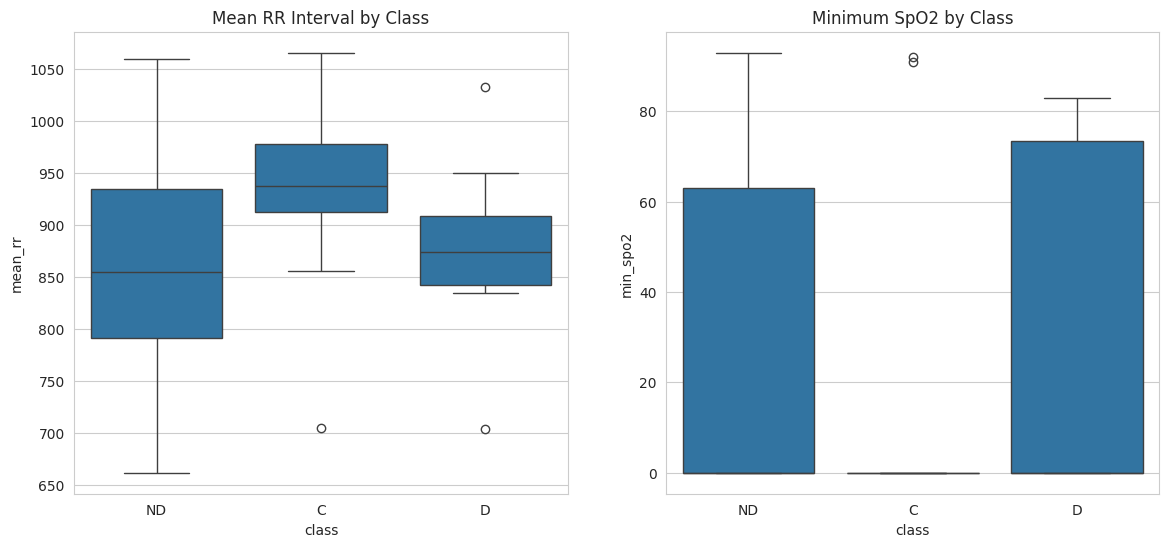

In [5]:
if not df_stats.empty:
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_stats, x='class', y='mean_rr')
    plt.title('Mean RR Interval by Class')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_stats, x='class', y='min_spo2')
    plt.title('Minimum SpO2 by Class')
    plt.show()

## 7. Key Findings <a id='findings'></a>

1. **Data Structure**: Confirmed `.mat` files with `RR_notch_abs_pr_ada` keys for RR intervals and `SAT` for SpO2. Data is stored in cell arrays where some initial cells are empty.
2. **Classes**: `C` (Control/Apnea), `D` (Apnea), `ND` (No Disease) groups identified.
3. **Signal Quality**: Valid signals extracted by skipping empty segments. SpO2 ranges vary significantly between classes.
